# 1. Import the Bitcoin data

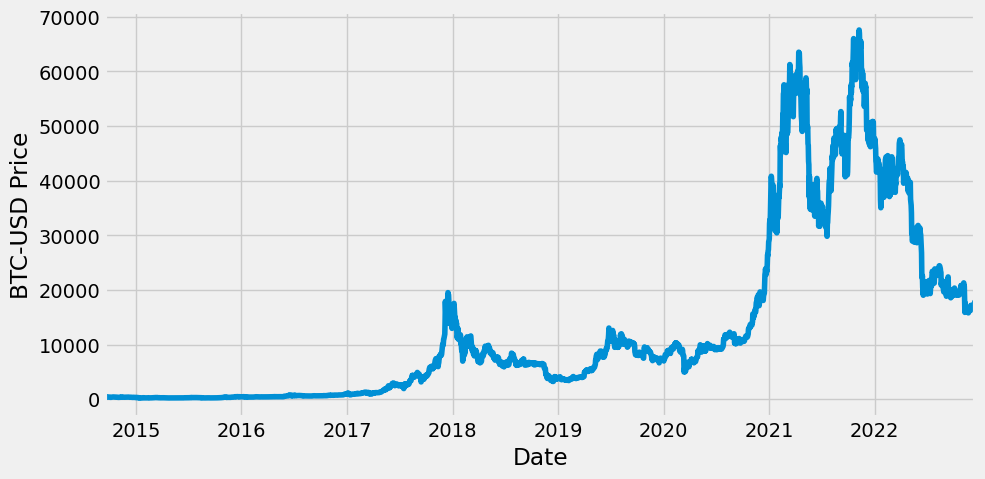

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Read BTCUSD data
df = pd.read_csv('BTC-USD.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df.Close.plot(figsize=(10, 5))
plt.ylabel('BTC-USD Price')
plt.show()

# 2. Compute the Ichimoku Cloud 

#### Tenkan-sen (Conversion Line): (20-period high + 20-period low)/2

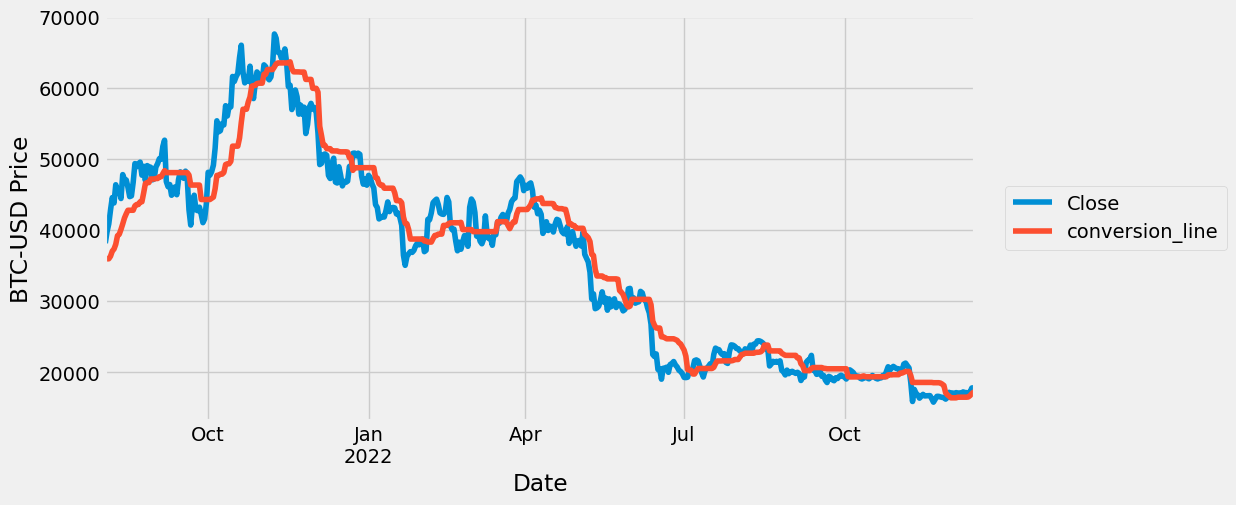

In [6]:
High_20 = df.High.rolling(20).max()
Low_20 = df.Low.rolling(20).min()
df['conversion_line'] = (High_20 + Low_20) / 2

conversion_line = df[['Close', 'conversion_line']]
conversion_line[-500:].plot(figsize=(10, 5))
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('BTC-USD Price')
plt.show()

#### Kijun-sen (Base Line): (60-period high + 60-period low)/2

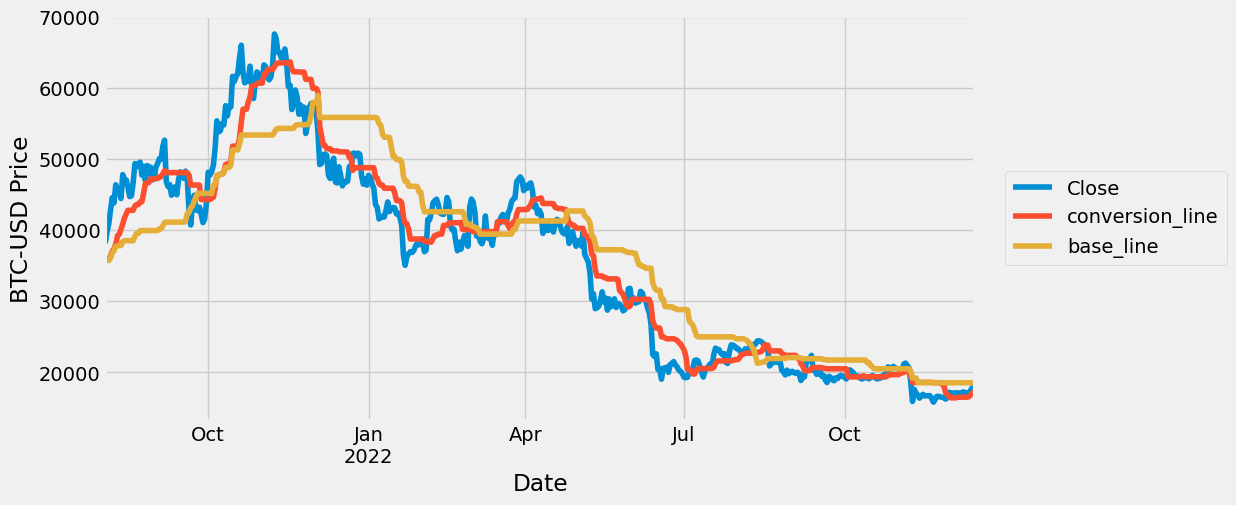

In [7]:
High_60 = df.High.rolling(60).max()
Low_60 = df.Low.rolling(60).min()
df['base_line'] = (High_60 + Low_60) / 2

base_line = df[['Close', 'conversion_line', 'base_line']]
base_line[-500:].plot(figsize=(10, 5))
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('BTC-USD Price')
plt.show()

#### Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2

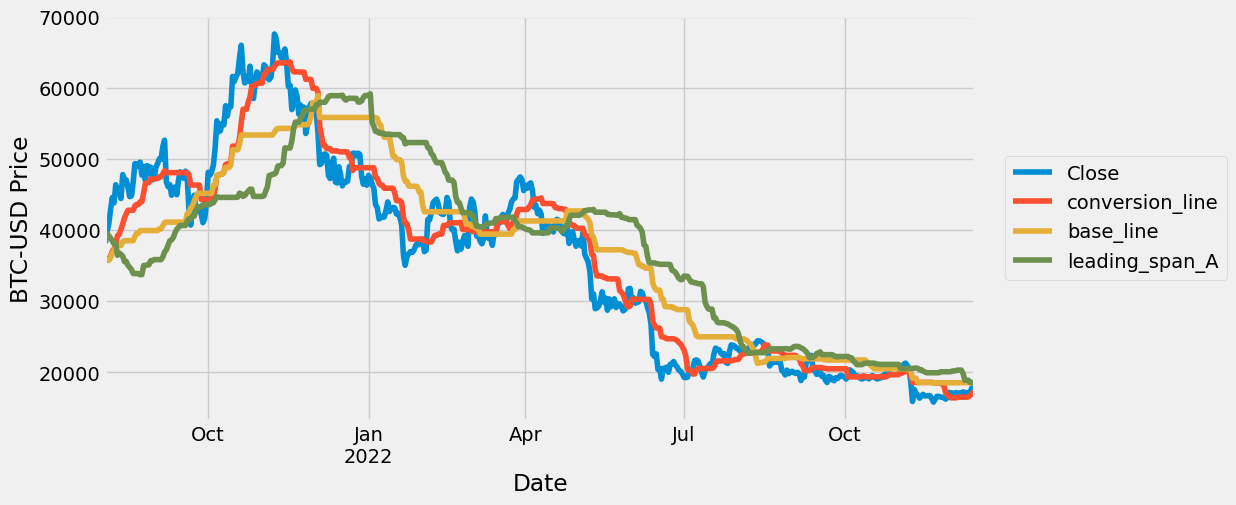

In [8]:
df['leading_span_A'] = ((df.conversion_line + df.base_line) / 2).shift(30)

leading_span_A = df[['Close', 'conversion_line',
                     'base_line', 'leading_span_A']]

leading_span_A[-500:].plot(figsize=(10, 5))
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('BTC-USD Price')
plt.show()

#### Senkou Span B (Leading Span B): (120-period high + 120-period low)/2

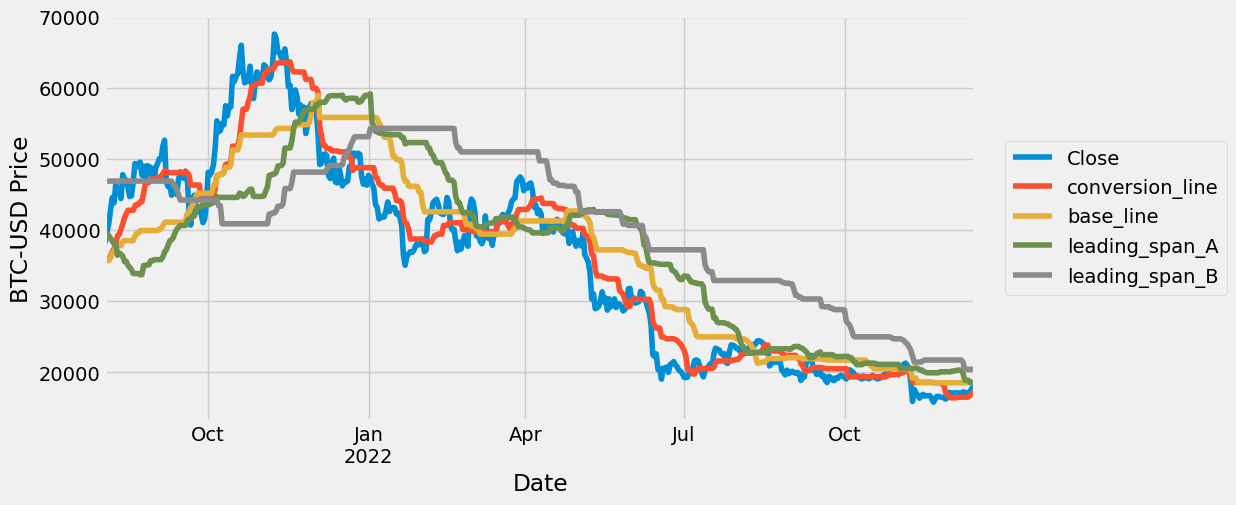

In [9]:
High_120 = df.High.rolling(120).max()
Low_120 = df.Low.rolling(120).min()
df['leading_span_B'] = ((High_120 + Low_120) / 2).shift(30)

leading_span_B = df[['Close', 'conversion_line',
                     'base_line', 'leading_span_A', 'leading_span_B']]
leading_span_B[-500:].plot(figsize=(10, 5))
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('BTC-USD Price')
plt.show()

#### Chikou Span (Lagging Span): Close plotted 30 days in the past

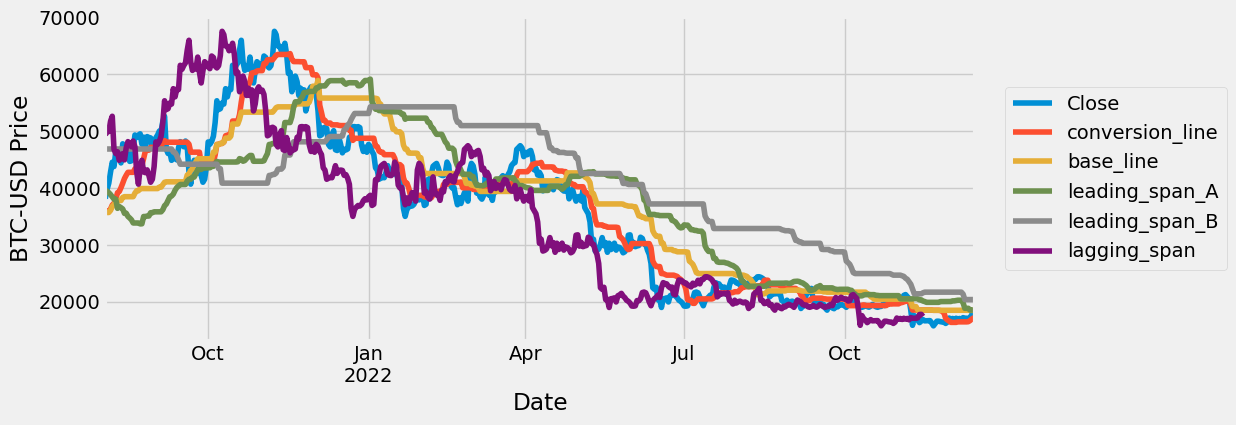

In [10]:
df['lagging_span'] = df.Close.shift(-30)

lagging_span = df[['Close', 'conversion_line', 'base_line',
                   'leading_span_A', 'leading_span_B', 'lagging_span']]
lagging_span[-500:].plot(figsize=(10, 4))
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('BTC-USD Price')
plt.show()

#### Ichimoku Cloud

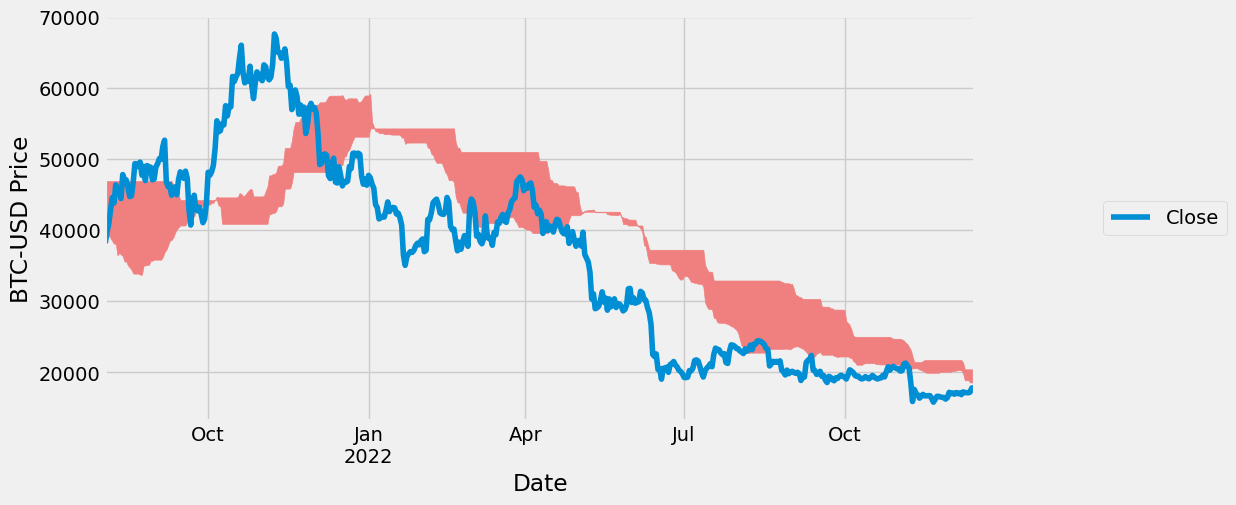

In [11]:
ichimoku_cloud = df[-500:].Close.plot(figsize=(10, 5))
ichimoku_cloud.fill_between(
    df[-500:].index, df[-500:].leading_span_A, df[-500:].leading_span_B, color='lightcoral')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('BTC-USD Price')
plt.show()

# 3. Trading signals

### 3.1 Entry Signal

In [12]:
import numpy as np
df['signal'] = np.nan

# Prices are above the cloud
condition_1 = (df.Close > df.leading_span_A) & (df.Close > df.leading_span_B)

# leading Span A (senkou_span_A) is rising above the leading span B (senkou_span_B)
condition_2 = (df.leading_span_A > df.leading_span_B)

# Conversion Line (tenkan_sen) moves above Base Line (kijun_sen)
condition_3 = (df.conversion_line > df.base_line)

# Combine the conditions and store in the signal column 1 when all the conditions are true
df.loc[condition_1 & condition_2 & condition_3, 'signal'] = 1

### 3.2 Exit signal

In [13]:
# Prices are below the cloud
condition_1 = (df.Close < df.leading_span_A) & (df.Close < df.leading_span_B)

# leading Span A (senkou_span_A) is falling below the leading span B (senkou_span_B)
condition_2 = (df.leading_span_A < df.leading_span_B)

# Conversion Line (tenkan_sen) moves below Base Line (kijun_sen)
condition_3 = (df.conversion_line < df.base_line)

# Combine the conditions and store in the signal column 0 when all the conditions are true
df.loc[condition_1 & condition_2 & condition_3, 'signal'] = 0

df.signal.fillna(method='ffill', inplace=True)

# 4. Strategy returns

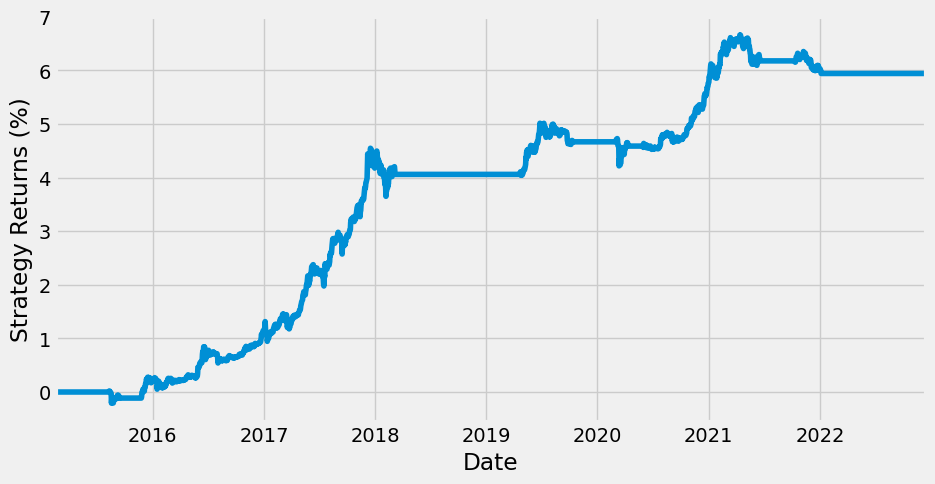

In [14]:
# Calculate daily returns
daily_returns = df.Close.pct_change()

# Calculate the strategy returns
strategy_returns = daily_returns * df.signal.shift(1)
strategy_returns.dropna(inplace=True)

# Plot the strategy returns
strategy_returns.cumsum().plot(figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Strategy Returns (%)')
plt.show()